# Using pyproj for rotated coordinate transformations

Create a dataset that will have not precise coordinate bounds.

In [1]:
import cf_xarray as cfxr
import numpy as np
import xarray as xr

ds = xr.Dataset(
    coords=dict(
        rlat=(["rlat"], [21.615, 21.725, 21.835]),
        rlon=(["rlon"], [17.935, 18.045, 18.155]),
    ),
    data_vars=dict(dummy=(["rlat", "rlon"], np.random.rand(3, 3)),),
)

ds

<xarray.Dataset>
Dimensions:  (rlat: 3, rlon: 3)
Coordinates:
  * rlat     (rlat) float64 21.61 21.73 21.84
  * rlon     (rlon) float64 17.93 18.05 18.16
Data variables:
    dummy    (rlat, rlon) float64 0.284 0.8978 0.4348 ... 0.1176 0.3468 0.3661

Choose these numbers since actually this should be true, but isn't (due to floating point limitations):

In [2]:
21.615 + 0.055 == 21.725 - 0.055  # e.g. right boundary of i-1 should be the same as left boundary of i

False

In our case, this means that boundaries of neigbhouring grid cells do not macht always, e.g.

In [3]:
rlon_bounds = ds.cf.add_bounds("rlon").rlon_bounds
np.all(rlon_bounds.isel(bounds=0).data[1:] == rlon_bounds.isel(bounds=1).data[:-1])

False

... but they are close

In [4]:
np.allclose(rlon_bounds.isel(bounds=0).data[1:], rlon_bounds.isel(bounds=1).data[:-1])

True

Now, define xarray wrapper for computing transformed coordinates

In [5]:
import cordex as cx
import numpy as np
import xarray as xr
from pyproj import CRS, Transformer

world = CRS("EPSG:4326")
world

rotated = CRS.from_cf(
    {
        "grid_mapping_name": "rotated_latitude_longitude",
        "grid_north_pole_latitude": 39.25,
        "grid_north_pole_longitude": -162.0,
    }
)


def _transform(x, y, src_crs, trg_crs):
    """helper function for transforming coordinates"""
    x_stack = np.broadcast_to(x, (y.shape[0], x.shape[0])).T
    y_stack = np.broadcast_to(y, (x.shape[0], y.shape[0]))
    transformer = Transformer.from_crs(src_crs, trg_crs)
    y_transform, x_transform = transformer.transform(x_stack, y_stack)
    return x_transform.T, y_transform.T


def transform(x, y, src_crs, trg_crs=None):
    """coordinate transformation of x and y."""
    if trg_crs is None:
        trg_crs = CRS("EPSG:4326")
    input_core_dims = [[x.dims[0]], [y.dims[0]]] + [[], []]
    output_core_dims = 2 * [[y.dims[0], x.dims[0]]]
    result = xr.apply_ufunc(
        _transform,
        x,
        y,
        src_crs,
        trg_crs,
        input_core_dims=input_core_dims,
        output_core_dims=output_core_dims,
    )
    result[0].name = "xt"
    result[1].name = "yt"
    return result

In [6]:
lon, lat = transform(ds.rlon, ds.rlat, rotated)
ds = ds.assign_coords(lon=lon, lat=lat)
ds

<xarray.Dataset>
Dimensions:  (rlat: 3, rlon: 3)
Coordinates:
  * rlat     (rlat) float64 21.61 21.73 21.84
  * rlon     (rlon) float64 17.93 18.05 18.16
    lon      (rlat, rlon) float64 64.22 64.42 64.63 64.38 ... 64.55 64.76 64.96
    lat      (rlat, rlon) float64 66.64 66.58 66.52 66.73 ... 66.81 66.75 66.69
Data variables:
    dummy    (rlat, rlon) float64 0.284 0.8978 0.4348 ... 0.1176 0.3468 0.3661

now we transform also the 1D boundaries into the global coordinates...

In [7]:
def lon_lat_bounds(ds, src_crs):
    # add 1d bounds
    rlon_bounds = ds.cf.add_bounds("rlon").rlon_bounds.drop("rlon_bounds")
    rlat_bounds = ds.cf.add_bounds("rlat").rlat_bounds.drop("rlat_bounds")
    # counterclockwise transformed boundaries
    bot_left = transform(
        rlon_bounds.isel(bounds=0), rlat_bounds.isel(bounds=0), src_crs
    )
    bot_right = transform(
        rlon_bounds.isel(bounds=1), rlat_bounds.isel(bounds=0), src_crs
    )
    top_right = transform(
        rlon_bounds.isel(bounds=1), rlat_bounds.isel(bounds=1), src_crs
    )
    top_left = transform(
        rlon_bounds.isel(bounds=0), rlat_bounds.isel(bounds=1), src_crs
    )
    lon_bounds = xr.concat(
        [bot_left[0], bot_right[0], top_right[0], top_left[0]], dim="vertices"
    )
    lat_bounds = xr.concat(
        [bot_left[1], bot_right[1], top_right[1], top_left[1]], dim="vertices"
    )
    return lon_bounds, lat_bounds

In [8]:
lon_bounds, lat_bounds = lon_lat_bounds(ds, rotated)
ds = ds.assign(lon_bounds=lon_bounds, lat_bounds=lat_bounds)
ds

<xarray.Dataset>
Dimensions:     (rlat: 3, rlon: 3, vertices: 4)
Coordinates:
  * rlat        (rlat) float64 21.61 21.73 21.84
  * rlon        (rlon) float64 17.93 18.05 18.16
    lon         (rlat, rlon) float64 64.22 64.42 64.63 ... 64.55 64.76 64.96
    lat         (rlat, rlon) float64 66.64 66.58 66.52 ... 66.81 66.75 66.69
Dimensions without coordinates: vertices
Data variables:
    dummy       (rlat, rlon) float64 0.284 0.8978 0.4348 ... 0.3468 0.3661
    lon_bounds  (vertices, rlat, rlon) float64 64.03 64.24 64.44 ... 64.74 64.95
    lat_bounds  (vertices, rlat, rlon) float64 66.63 66.56 66.5 ... 66.83 66.76

quick plot for convenience

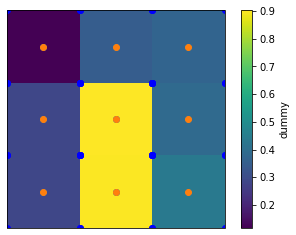

In [9]:
from cartopy import crs as ccrs
from matplotlib import pyplot as plt

rotated = ccrs.RotatedPole(pole_longitude=-162.0, pole_latitude=39.25)
ax = plt.subplot(projection=rotated)

# plot cell centers
ds.dummy.plot.pcolormesh(x="rlon", y="rlat", ax=ax)
# plot cell centers
# xr.plot.scatter(subset, x='lon', y='lat', transform=ccrs.PlateCarree())
xr.plot.scatter(ds, x="rlon", y="rlat", transform=rotated)
# plot cell vertices
xr.plot.scatter(ds, x="lon", y="lat", transform=ccrs.PlateCarree())
xr.plot.scatter(
    ds, x="lon_bounds", y="lat_bounds", color="b", transform=ccrs.PlateCarree()
)

Now, let cf_xarray try to determine vertices order (`order=None`), [xesmf relies on this](https://github.com/pangeo-data/xESMF/blob/d48285b5f65bd97820154f0253386ef69f65a36b/xesmf/frontend.py#L84) for conservative regridding...

In [10]:
lon_vertices = cfxr.bounds_to_vertices(
    ds.lon_bounds, bounds_dim="vertices", order="counterclockwise"
)

counterclockwise


In [11]:
# this should also result in counterclockwise but doesn't...
lon_vertices_ = cfxr.bounds_to_vertices(
    ds.lon_bounds, bounds_dim="vertices", order=None
)

clockwise


In [12]:
lon_vertices.equals(lon_vertices_)

False

because our curvilinear coordinate boundaries of neighbouring cells do not match exactly

In [13]:
import numpy as np

np.set_printoptions(precision=14)
ds.lon_bounds.isel(rlon=1, rlat=1, vertices=0), ds.lon_bounds.isel(
    rlon=0, rlat=1, vertices=1
)

(<xarray.DataArray 'lon_bounds' ()>
 array(64.40397614495)
 Coordinates:
     rlat     float64 21.73
     rlon     float64 18.05
     lon      float64 64.59
     lat      float64 66.66,
 <xarray.DataArray 'lon_bounds' ()>
 array(64.40397614494998)
 Coordinates:
     rlat     float64 21.73
     rlon     float64 17.93
     lon      float64 64.38
     lat      float64 66.73)